<a href="https://colab.research.google.com/github/akankshakusf/Project-Deep-Learning-CNN-Malaria-Detection/blob/master/Malaria_Improvised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import ML packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
import cv2  #computer vision
from sklearn.metrics import confusion_matrix,roc_curve

#import DL tensorflow packages
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import albumentations as A
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer,BatchNormalization, Input,InputLayer,Conv2D, MaxPool2D, Flatten,Dense,Dropout
from tensorflow.keras.layers import RandomFlip,RandomRotation,Resizing,Rescaling,Reshape  #for data augmentation
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,FalseNegatives,FalsePositives,TruePositives,\
TrueNegatives,Precision,Recall,AUC
from tensorboard.plugins.hparams import api as hp

#import wandb packages
import wandb
from wandb.integration.keras import WandbCallback


# Data Preparation

## Data Loading

In [45]:
dataset, datainfo  = tfds.load('malaria',with_info = True,
                               as_supervised=True,
                               shuffle_files = True,
                               split = ['train'])

In [3]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [16]:
# def to make train,test, val script
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset) #total dataset

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))  ##train data

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE)) #val data

  test_dataset =val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE)) #test data
  return train_dataset, val_dataset , test_dataset

In [15]:
'''
  Uncomment to understand the train, test and val splits better
'''
###### split function logic explaination builder ######

# TRAIN_RATIO = 0.6
# TEST_RATIO= 0.2
# VAL_RATIO=0.2
# TOTAL = 10
# ds = tf.data.Dataset.range(TOTAL)
# print(ds)
# #make train,test,val splits
# train_ds = ds.take(int(TRAIN_RATIO*10))
# val_test_ds = ds.skip(int(TRAIN_RATIO*10))
# val_ds = val_test_ds.take(int(VAL_RATIO*TOTAL))
# test_ds =val_test_ds.skip(int(VAL_RATIO*TOTAL))

# #print to see better
# print([int(x) for x in ds.as_numpy_iterator()]) #total
# print([int(x) for x in train_ds.as_numpy_iterator()]) #train dataset
# print([int(x) for x in val_test_ds.as_numpy_iterator()])
# print([int(x) for x in val_ds.as_numpy_iterator()]) #val_dataset
# print([int(x) for x in test_ds.as_numpy_iterator()]) #test_dataset

<_RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7, 8, 9]
[6, 7]
[8, 9]


In [17]:
#make the train,val ,test split
TRAIN_RATIO = 0.8
TEST_RATIO= 0.1
VAL_RATIO=0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO )

In [43]:
# Check dataset sizes
print(f"Training size: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training size: 22046
Validation size: 2755
Test size: 2757


In [19]:
datainfo

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [21]:
#check to values in the datainfo
print(datainfo.features['label'].int2str(0))
print(datainfo.features['label'].int2str(1))

parasitized
uninfected


## Dataset Visualization


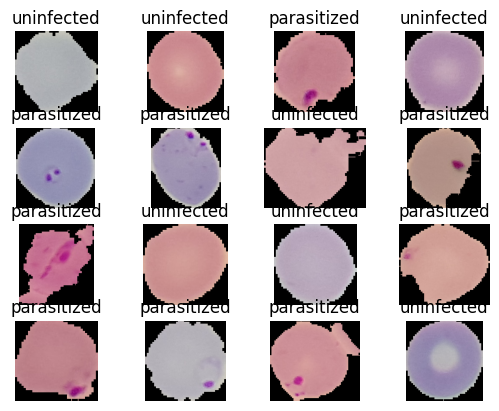

In [18]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)

  plt.imshow(image)
  plt.title(datainfo.features['label'].int2str(label))
  plt.axis('off')

## Data Preprocessing

### Data Augmentation  (Only Resizing technique)

- These images are of bigger sizes (255,255,3) etc. But we will have to Normalize them and bring them in the range of 0-1 so Deep learningn model converges or inference faster

In [33]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [34]:
# pick up 1 image from training dataset
original_image, label = next(iter(train_dataset))

In [35]:
# set augment method : Saturation
augmented_image= tf.image.adjust_saturation(original_image, saturation_factor=0.3)

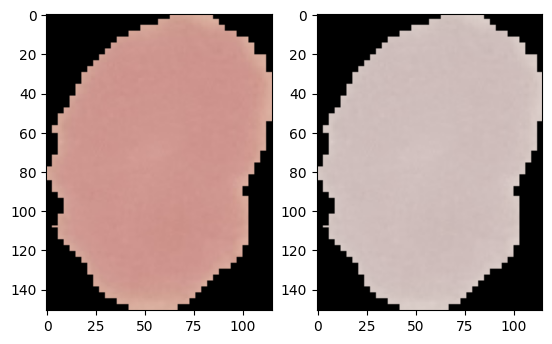

In [36]:
# Call the function
visualize(original_image, augmented_image)

In [37]:
IM_SIZE = 224

In [38]:
# data Augmentation
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [39]:
#TEST THE FUNCTION
resize_rescale(original_image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], 

- Note that now the image size is reduced to 224,224, 3

*  now apply function to all datasets we have

In [40]:
train_dataset = train_dataset.map(resize_rescale)

In [41]:
for image , label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [42]:
# check the values again in training data
np.unique(image)

array([0.0000000e+00, 2.4972958e-05, 2.5500556e-05, ..., 8.5091227e-01,
       8.5093659e-01, 8.5098040e-01], dtype=float32)

- Notice that all values are between 0-1 now

# Building advanced Models with Functional API, Subclassing and Custom Layers using Keras API

## Basic: Sequential API:LeNet Model

- This exact model summary is explained with full walk through in notion https://www.notion.so/CNN-Layering-Neuron-Count-1bc4ba18200f80ffa385ea743e4a30cd

In [45]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''

model = tf.keras.Sequential([
                             InputLayer(shape = (IM_SIZE,IM_SIZE, 3)),

                             # 1st conv layer (extracts basic patterns)
                             Conv2D(filters = 6, kernel_size = 5, strides=1, padding='valid', activation ='sigmoid'),
                             MaxPool2D(pool_size= 2, strides=2),

                             Flatten(),



                             Dense(1000, activation = "sigmoid"),
                             Dense(100, activation = "sigmoid"),
                             Dense(2, activation = "sigmoid"),
                             Dense(1),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 72600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1000)                │      72,601,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             202 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,701,761 (277.34 MB)

 Trainable params: 72,701,761 (277.34 MB)

 Non-trainable params: 0 (0.00 B)